In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [ ]:
%pip install gdown

In [ ]:
RANDOM_STATE = 42

In [ ]:
CARS_FILE_ID = '1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI'

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

!gdown --id {CARS_FILE_ID}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI
From (redirected): https://drive.google.com/uc?id=1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI&confirm=t&uuid=bc5e8c51-6f64-4694-846a-ecbed982bc2a
To: /content/dataset.csv
100% 1.01G/1.01G [00:06<00:00, 146MB/s]


In [ ]:
df = pd.read_csv('dataset.csv')
print(df.shape)

(604047, 24)


In [ ]:
df_with_na_column = df[df['engine_displacement'].isna()]
df_with_na_column

,production_year,mileage,condition,owners_number,pts_original,horse_power,accidents_resolution,region,seller_type,brand,...,engine_displacement,engine_power,fuel_rate,steering_wheel,price,price_segment,tags,auto_class,equipment,complectation_available_options
210905,2003,175000,CONDITION_OK,0,True,NaN,NaN,Чебаркуль,PRIVATE,Hyundai,...,NaN,NaN,NaN,LEFT,380000,MEDIUM,available_for_checkup;pts_original;real_photo;...,NaN,seats-5,NaN


In [ ]:
df.drop(210905, inplace=True)

In [ ]:
df['fuel_rate'].fillna(df['fuel_rate'].median(), inplace=True)

<ipython-input-10-b50b155cf67a>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fuel_rate'].fillna(df['fuel_rate'].median(), inplace=True)


In [ ]:
df['pts_original'].fillna(True, inplace=True)
df['accidents_resolution'].fillna('OK', inplace=True)
df['auto_class'].fillna('NOT SPECIFIED', inplace=True)

<ipython-input-11-f268849e3c66>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pts_original'].fillna(True, inplace=True)
<ipython-input-11-f268849e3c66>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pts_original'].fillna(True, inplace=True)
<ipython-input-11-f268849e3c66>:2: FutureWarning: A value 

In [ ]:
df.drop('horse_power', axis=1, inplace=True)

In [ ]:
def get_unique_values(series, sep=';'):
    uniq = set()
    for cell in series.dropna():
        for piece in cell.split(sep):
            s = piece.strip()
            if s:
                uniq.add(s)
    return np.array(list(uniq))

all_tags = get_unique_values(df['tags'])
all_options = get_unique_values(df['complectation_available_options'])
all_equipments = get_unique_values(df['equipment'])

In [ ]:
def create_binary_features(df, column, unique_values, sep=';'):
    return (
        df[column]
        .str.get_dummies(sep=sep)
        .reindex(columns=unique_values, fill_value=0)
        .astype('int8')
    )

tags_dummies = create_binary_features(df, 'tags', all_tags)
options_dummies = create_binary_features(df, 'complectation_available_options', all_options)
equipment_dummies = create_binary_features(df, 'equipment', all_equipments)

In [ ]:
tags_dummies = tags_dummies.astype('Sparse[int]')
options_dummies = options_dummies.astype('Sparse[int]')
equipment_dummies = equipment_dummies.astype('Sparse[int]')

In [ ]:
full_df = pd.concat([
    df.drop(columns=['tags', 'complectation_available_options', 'equipment']),
    tags_dummies,
    options_dummies.drop(columns=['condition']),
    equipment_dummies.drop(columns=['condition'])
], axis=1)

In [ ]:
duplicated_cols = full_df.columns[full_df.columns.duplicated()].unique()
for col in duplicated_cols:
    full_df[col] = full_df[col].astype("int8")

In [ ]:
import numpy as np

names = full_df.columns[full_df.columns.duplicated()].unique()
new_cols = {}

for name in names:
    cols_i = [col for col in full_df.columns if col == name]
    sub_df = full_df.loc[:, cols_i].astype('int8')   # DataFrame shape (n_rows, k)

    # берём максимум по строкам → Series shape (n_rows,)
    max_series = sub_df.max(axis=1).astype('int8')

    new_cols[name] = max_series

    # удаляем *все* старые колонки с этим именем
    full_df.drop(columns=cols_i, inplace=True)

# теперь присваиваем новые колонки–Series (они одномерны!)
for name, s in new_cols.items():
    full_df[name] = s


<ipython-input-18-65bc9051fcec>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df[name] = s
<ipython-input-18-65bc9051fcec>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df[name] = s
<ipython-input-18-65bc9051fcec>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df[name] = s
<

In [ ]:
full_df.sample(10)

,production_year,mileage,condition,owners_number,accidents_resolution,region,seller_type,brand,model,body_type,...,reduce-spare-wheel,multizone-climate-control,isofix-front,roof-rails,19-inch-wheels,voice-recognition,asr,collision-prevention-assist,heated-wash-system,volume-sensor
436947,2024,0,CONDITION_OK,0,OK,Санкт-Петербург,COMMERCIAL,Skoda,Karoq,ALLROAD_5_DOORS,...,0,0,0,1,0,0,0,0,0,0
329729,2020,40460,CONDITION_OK,1,ERROR,Москва,PRIVATE,Mercedes-Benz,E-Класс,COUPE_HARDTOP,...,0,0,0,0,0,0,0,0,1,1
343497,2000,380000,CONDITION_OK,4,OK,Москва,PRIVATE,Mercedes-Benz,M-Класс,ALLROAD_5_DOORS,...,0,0,0,0,0,0,0,0,0,0
439784,2019,170000,CONDITION_OK,1,ERROR,Москва,PRIVATE,Skoda,Octavia,LIFTBACK,...,0,0,0,0,0,1,0,0,0,1
550845,2023,107,CONDITION_OK,1,OK,Краснодар,PRIVATE,Lada (ВАЗ),Largus,WAGON_5_DOORS,...,0,0,0,1,0,0,0,0,0,0
431808,2015,110727,CONDITION_OK,1,OK,Уфа,COMMERCIAL,Renault,Sandero,HATCHBACK_5_DOORS,...,0,0,0,1,0,0,0,0,0,0
167063,2024,0,CONDITION_OK,0,OK,Химки,COMMERCIAL,Genesis,GV80 Coupe,ALLROAD_5_DOORS,...,0,1,0,1,0,0,1,1,0,0
391523,2022,13000,CONDITION_OK,0,OK,Владивосток,COMMERCIAL,Nissan,X-Trail,ALLROAD_5_DOORS,...,0,0,0,0,0,0,0,0,0,0
210052,2024,100,CONDITION_OK,1,OK,Новосибирск,PRIVATE,Hyundai,Elantra,SEDAN,...,0,0,0,0,0,0,0,0,0,0
46816,2024,34,CONDITION_OK,1,OK,Москва,COMMERCIAL,BMW,X5,ALLROAD_5_DOORS,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

numeric_df = full_df.select_dtypes(include=[np.number])
numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]

corr = numeric_df.corr().abs().fillna(0)

dist = 1 - corr

dist = (dist + dist.T) / 2
np.fill_diagonal(dist.values, 0)

dist = dist.clip(lower=0)

dist_vect = squareform(dist)
Z = hierarchy.linkage(dist_vect, method='average')

max_d = 0.4
clusters = hierarchy.fcluster(Z, t=max_d, criterion='distance')

cluster_df = pd.DataFrame({'feature': numeric_df.columns, 'cluster': clusters})
to_keep = []
for c in cluster_df['cluster'].unique():
    members = cluster_df.loc[cluster_df['cluster'] == c, 'feature']
    avg_corr = corr.loc[members, members].mean().sort_values(ascending=False)
    to_keep.append(avg_corr.index[0])
to_keep = list(dict.fromkeys(to_keep))

to_drop = [col for col in numeric_df.columns if col not in to_keep]
df_reduced = full_df.drop(columns=to_drop)

print(f"Удалено числовых коррелирующих признаков: {len(to_drop)}")
print(f"Осталось признаков в df_reduced: {df_reduced.shape[1]} из {full_df.shape[1]}")

Удалено числовых коррелирующих признаков: 115
Осталось признаков в df_reduced: 301 из 416


In [ ]:
df_reduced.sample(10)

,mileage,condition,accidents_resolution,region,seller_type,brand,model,body_type,doors_count,seats,...,18-inch-wheels,driver-seat-electric,front-seats-heat-vent,reduce-spare-wheel,multizone-climate-control,isofix-front,roof-rails,19-inch-wheels,voice-recognition,volume-sensor
518746,33000,CONDITION_OK,ERROR,Аксай,PRIVATE,Lada (ВАЗ),2107,SEDAN,4,5,...,0,0,0,0,0,0,0,0,0,0
224119,23211,CONDITION_OK,OK,Москва,PRIVATE,Hyundai,Solaris,SEDAN,4,5,...,0,0,0,0,0,0,0,0,0,0
351020,6122,CONDITION_OK,OK,Уссурийск,COMMERCIAL,Mini,Countryman,ALLROAD_5_DOORS,5,5,...,0,0,0,0,0,0,0,0,0,0
424138,4500,CONDITION_OK,ERROR,Погар,PRIVATE,Renault,Kaptur,ALLROAD_5_DOORS,5,5,...,0,0,0,0,0,0,0,0,0,0
89776,245600,CONDITION_OK,OK,Тверь,PRIVATE,Chevrolet,Aveo,SEDAN,4,5,...,0,0,0,0,0,0,0,0,0,0
297634,18300,CONDITION_OK,OK,Москва,PRIVATE,Lexus,RX,ALLROAD_5_DOORS,5,5,...,0,1,1,0,1,0,1,0,0,0
449720,0,CONDITION_OK,OK,Москва,COMMERCIAL,Soueast,S07,ALLROAD_5_DOORS,5,5;7,...,0,1,1,0,1,0,1,1,1,0
49847,121000,CONDITION_OK,OK,Москва,PRIVATE,BMW,X6,ALLROAD_5_DOORS,5,5,...,0,1,0,0,0,0,0,1,1,1
48872,0,CONDITION_OK,OK,Краснодар,COMMERCIAL,BMW,X6,ALLROAD_5_DOORS,5,5,...,0,0,0,0,0,0,0,0,0,0
846,363500,CONDITION_OK,OK,Уфа,PRIVATE,Alfa Romeo,166,SEDAN,4,5,...,0,1,0,0,0,0,0,0,0,0


### Добавим новые признаки

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
df_mod = df_reduced.copy()

In [ ]:
df_mod["age"] = 2025 - df["production_year"]

In [ ]:
numeric_cols = ['mileage', 'engine_displacement', 'engine_power', 'age']

In [ ]:
df_mod['log_price'] = np.log1p(df['price'])

In [ ]:
df_mod.drop(columns=['price'], inplace=True)

Прологарифмируем некоторые признаки

In [ ]:
for col in numeric_cols:
    df_mod[f'log_{col}'] = np.log1p(df_mod[col])

Возьмем корни от числовых признаков

In [ ]:
for col in numeric_cols:
    df_mod[f'square_{col}'] = df_mod[col]**2

Полиномиальные преобразования

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_array = poly.fit_transform(df_mod[numeric_cols].fillna(0))
poly_feature_names = poly.get_feature_names_out(numeric_cols)
poly_df = pd.DataFrame(poly_array, columns=poly_feature_names, index=df_mod.index)

In [ ]:
poly_new = poly_df.drop(columns=[c for c in poly_df.columns if c in numeric_cols])
df_mod = pd.concat([df_mod, poly_new.add_prefix('poly_')], axis=1)

Базовые отношения двигателя

In [ ]:
df_mod['power_to_disp'] = df['engine_power'] / df['engine_displacement'].clip(lower=0.01)

Арифметичесике преобразования

In [ ]:
# Произведения признаков
df_mod['mileage_x_power'] = df['mileage'] * df['engine_power']
df_mod['disp_x_power'] = df['engine_displacement'] * df['engine_power']
df_mod['owners_x_power'] = df['owners_number'] * df['engine_power']
df_mod["age_x_power"]    = df_mod["age"] * df["engine_power"]
df_mod["age_x_mileage"]  = df_mod["age"] * df["mileage"]

# Частные признаков
df_mod['power_div_mileage'] = df['engine_power'] / df['mileage'].clip(lower=0.01)
df_mod['disp_per_mile'] = df['engine_displacement'] / df['mileage'].clip(lower=0.01)
df_mod['mileage_per_hp'] = df['mileage'] / df['engine_power'].clip(lower=0.01)
df_mod['milage_per_year'] = df['mileage'] / df_mod['age'].clip(lower=0.01)
df_mod['power_div_owners'] = df['engine_power'] / df['owners_number'].clip(lower=0.01)
df_mod['disp_div_owners'] = df['engine_displacement'] / df['owners_number'].clip(lower=0.01)

# Лог-взаимодействие
df_mod['log_mileage_x_log_power'] = df_mod['log_mileage'] * df_mod['log_engine_power']
df_mod['log_age_x_log_power'] = df_mod['log_age'] * df_mod['log_engine_power']

# Разности признаков
df_mod['power_minus_disp'] = df['engine_power'] - df['engine_displacement']

In [ ]:
from pandas.api.types import is_numeric_dtype

# Отношение дверей к местам
df_mod['seats_num'] = df['seats'].str.extract(r'(\d+)').astype(float)
df_mod['doors_to_seats_ratio'] = df['doors_count'] / df_mod['seats_num'].clip(lower=0.01)

# Индикатор аварий
df_mod['has_accident'] = (
    ~df['accidents_resolution'].fillna('none').str.lower().isin(['none', 'no', 'unknown'])
).astype(int)

# Сумма бинарных признаков
binary_cols = [
    col for col in df.columns
    if is_numeric_dtype(df[col]) and
       set(df[col].dropna().unique()).issubset({0, 1})
]
df_mod['num_binary_features'] = df[binary_cols].sum(axis=1)

# Счетчики безопасности и комфорта
safety_keywords = ['airbag', 'detection', 'vsm', 'ldw', 'tja', 'rcta', 'ptf']
safety_cols = [c for c in df.columns if any(k in c.lower() for k in safety_keywords)]
df_mod['safety_feature_count'] = df[safety_cols].sum(axis=1)

comfort_keywords = ['heat', 'leather', 'massage', 'climate', 'vent', 'seat']
comfort_cols = [c for c in df.columns if any(k in c.lower() for k in comfort_keywords)]
df_mod['comfort_feature_count'] = df[comfort_cols].sum(axis=1)

# Количество preset-тегов
preset_cols = [c for c in df.columns if c.startswith('preset')]
df_mod['num_presets'] = df[preset_cols].sum(axis=1)

# Является ли машина новой
df_mod['is_new'] = ((df['mileage'] < 1000) & (df['owners_number'] <= 1)).astype(int)
df_mod['is_very_old'] = (df_mod['age'] > 20).astype(int)

df_mod['is_one_owner'] = (df['owners_number'] == 1).astype(int)

Проверим, что нет дубликатов

In [ ]:
df_mod.columns.duplicated().sum()

np.int64(0)

Проверим, что не появилось пустых значений

In [ ]:
cols_with_na = df_mod.columns[df_mod.isna().any()].tolist()
print("Колонки с пропусками:", cols_with_na)

Колонки с пропусками: []


### Обучим CatBoost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.3 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.7 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.trial import TrialState
from catboost import CatBoostRegressor, utils as cb_utils
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score
import joblib

In [ ]:
X = df_mod.drop('log_price', axis=1)
y = df_mod['log_price']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [ ]:
num_features = X.select_dtypes(include=['int64','float64','int8']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
])

In [ ]:
X_train_proc = preprocessor.fit_transform(X_train)
X_valid_proc = preprocessor.transform(X_valid)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [ ]:
n_gpus = cb_utils.get_gpu_device_count()
if n_gpus == 0:
    raise RuntimeError("GPU не найдена!")
devices = ",".join(str(i) for i in range(n_gpus))

In [ ]:
N_TRIALS = 50

def objective(trial):
    params = {
        'task_type':     'GPU',
        'devices':       devices,
        'gpu_ram_part':  0.8,
        'iterations':    trial.suggest_int('iterations',   200, 2000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'depth':         trial.suggest_int('depth',        4,  10),
        'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),
        'border_count':  trial.suggest_int('border_count', 32, 255),
        'random_seed':   RANDOM_STATE,
        'verbose':       False,
    }
    model = CatBoostRegressor(**params)
    model.fit(
        X_train_proc, y_train,
        eval_set=(X_valid_proc, y_valid),
        early_stopping_rounds=50
    )
    preds = model.predict(X_valid_proc)
    return r2_score(y_valid, preds)

def progress_cb(study, trial):
    done = len([t for t in study.trials if t.state == TrialState.COMPLETE])
    print(f"Completed {done}/{N_TRIALS} trials")

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=1,
    show_progress_bar=True,
    callbacks=[progress_cb]
)

best = study.best_params
best.update({'task_type':'GPU','devices':devices,'gpu_ram_part':0.8,'random_seed':RANDOM_STATE,'verbose':False})
final_model = CatBoostRegressor(**best)
final_model.fit(X_train_proc, y_train, eval_set=(X_valid_proc, y_valid), early_stopping_rounds=N_TRIALS)

joblib.dump(final_model, 'drive/MyDrive/ML_project/best_catboost_model_with_new_feature.pkl')
joblib.dump(preprocessor, 'drive/MyDrive/ML_project/preprocessor_with_new_feature.pkl')
print("Models saved to best_catboost_model.pkl and preprocessor.pkl")

print("Best R²:", study.best_value)
print("Best params:", study.best_params)

[I 2025-06-09 20:02:59,038] A new study created in memory with name: no-name-064eb0c3-3b37-44a6-ab2f-6b16a1a6feaf


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:05:03,273] Trial 0 finished with value: 0.972180266062258 and parameters: {'iterations': 1125, 'learning_rate': 0.07794437236465629, 'depth': 8, 'l2_leaf_reg': 3.917501811933218, 'border_count': 150}. Best is trial 0 with value: 0.972180266062258.
Completed 1/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:07:03,000] Trial 1 finished with value: 0.9731493681979729 and parameters: {'iterations': 669, 'learning_rate': 0.06477033859403573, 'depth': 10, 'l2_leaf_reg': 0.27130572234470207, 'border_count': 195}. Best is trial 1 with value: 0.9731493681979729.
Completed 2/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:08:53,768] Trial 2 finished with value: 0.9632169932921048 and parameters: {'iterations': 1089, 'learning_rate': 0.048488865009547986, 'depth': 5, 'l2_leaf_reg': 0.165778137750049, 'border_count': 223}. Best is trial 1 with value: 0.9731493681979729.
Completed 3/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:10:44,415] Trial 3 finished with value: 0.9386074848513986 and parameters: {'iterations': 538, 'learning_rate': 0.012746437845477746, 'depth': 5, 'l2_leaf_reg': 2.415166341272708, 'border_count': 93}. Best is trial 1 with value: 0.9731493681979729.
Completed 4/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:12:45,504] Trial 4 finished with value: 0.8201974111261411 and parameters: {'iterations': 623, 'learning_rate': 0.001858520886037547, 'depth': 10, 'l2_leaf_reg': 2.67111711036522, 'border_count': 203}. Best is trial 1 with value: 0.9731493681979729.
Completed 5/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:14:32,671] Trial 5 finished with value: 0.9256400877861668 and parameters: {'iterations': 464, 'learning_rate': 0.008672092679863047, 'depth': 5, 'l2_leaf_reg': 0.44136789302368074, 'border_count': 89}. Best is trial 1 with value: 0.9731493681979729.
Completed 6/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:16:30,111] Trial 6 finished with value: 0.9702769472289043 and parameters: {'iterations': 982, 'learning_rate': 0.061868252932534964, 'depth': 8, 'l2_leaf_reg': 8.30264860039305, 'border_count': 209}. Best is trial 1 with value: 0.9731493681979729.
Completed 7/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:18:34,788] Trial 7 finished with value: 0.8578823016654236 and parameters: {'iterations': 1470, 'learning_rate': 0.0010005379131438898, 'depth': 8, 'l2_leaf_reg': 5.448822699267552, 'border_count': 53}. Best is trial 1 with value: 0.9731493681979729.
Completed 8/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:20:29,591] Trial 8 finished with value: 0.960401017167982 and parameters: {'iterations': 912, 'learning_rate': 0.021984079997240304, 'depth': 7, 'l2_leaf_reg': 9.07518644595831, 'border_count': 128}. Best is trial 1 with value: 0.9731493681979729.
Completed 9/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:22:42,438] Trial 9 finished with value: 0.9238651364535029 and parameters: {'iterations': 1792, 'learning_rate': 0.0015922489415796776, 'depth': 7, 'l2_leaf_reg': 0.9358258516031683, 'border_count': 227}. Best is trial 1 with value: 0.9731493681979729.
Completed 10/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:24:36,007] Trial 10 finished with value: 0.8677226793843463 and parameters: {'iterations': 287, 'learning_rate': 0.00505140527786175, 'depth': 10, 'l2_leaf_reg': 0.1298821787215254, 'border_count': 163}. Best is trial 1 with value: 0.9731493681979729.
Completed 11/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:26:48,216] Trial 11 finished with value: 0.9753105768352747 and parameters: {'iterations': 1409, 'learning_rate': 0.07507748096019781, 'depth': 9, 'l2_leaf_reg': 0.4384973286352567, 'border_count': 163}. Best is trial 11 with value: 0.9753105768352747.
Completed 12/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:29:11,737] Trial 12 finished with value: 0.9734869408570316 and parameters: {'iterations': 1482, 'learning_rate': 0.029838837863391938, 'depth': 10, 'l2_leaf_reg': 0.3206651606720674, 'border_count': 255}. Best is trial 11 with value: 0.9753105768352747.
Completed 13/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:31:26,913] Trial 13 finished with value: 0.970599470521169 and parameters: {'iterations': 1433, 'learning_rate': 0.02609448711677762, 'depth': 9, 'l2_leaf_reg': 0.6211807402138035, 'border_count': 254}. Best is trial 11 with value: 0.9753105768352747.
Completed 14/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:33:44,938] Trial 14 finished with value: 0.9721425024965091 and parameters: {'iterations': 1813, 'learning_rate': 0.026195195281592698, 'depth': 9, 'l2_leaf_reg': 0.33479885798844344, 'border_count': 167}. Best is trial 11 with value: 0.9753105768352747.
Completed 15/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:35:57,070] Trial 15 finished with value: 0.9725487709529811 and parameters: {'iterations': 1485, 'learning_rate': 0.03853774061073394, 'depth': 9, 'l2_leaf_reg': 1.269391642799333, 'border_count': 251}. Best is trial 11 with value: 0.9753105768352747.
Completed 16/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:38:02,963] Trial 16 finished with value: 0.9721244177280112 and parameters: {'iterations': 1966, 'learning_rate': 0.09067100954159787, 'depth': 6, 'l2_leaf_reg': 0.10184798013153286, 'border_count': 116}. Best is trial 11 with value: 0.9753105768352747.
Completed 17/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:40:07,880] Trial 17 finished with value: 0.9653429964704282 and parameters: {'iterations': 1298, 'learning_rate': 0.01385417924494549, 'depth': 9, 'l2_leaf_reg': 0.24383479406440461, 'border_count': 34}. Best is trial 11 with value: 0.9753105768352747.
Completed 18/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:42:06,786] Trial 18 finished with value: 0.9388686385958526 and parameters: {'iterations': 1652, 'learning_rate': 0.005771784401360377, 'depth': 4, 'l2_leaf_reg': 0.6675842217226533, 'border_count': 177}. Best is trial 11 with value: 0.9753105768352747.
Completed 19/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:44:15,525] Trial 19 finished with value: 0.9730904816935674 and parameters: {'iterations': 1260, 'learning_rate': 0.032373504845066826, 'depth': 10, 'l2_leaf_reg': 0.19100601212807106, 'border_count': 88}. Best is trial 11 with value: 0.9753105768352747.
Completed 20/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:46:20,678] Trial 20 finished with value: 0.9731619520487023 and parameters: {'iterations': 1640, 'learning_rate': 0.09584154923542924, 'depth': 7, 'l2_leaf_reg': 1.5585592815893763, 'border_count': 186}. Best is trial 11 with value: 0.9753105768352747.
Completed 21/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:48:27,045] Trial 21 finished with value: 0.9732374070240217 and parameters: {'iterations': 1620, 'learning_rate': 0.09547871001640416, 'depth': 7, 'l2_leaf_reg': 1.4571768207001883, 'border_count': 134}. Best is trial 11 with value: 0.9753105768352747.
Completed 22/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:50:24,562] Trial 22 finished with value: 0.9687785603145761 and parameters: {'iterations': 1630, 'learning_rate': 0.04975375012425441, 'depth': 6, 'l2_leaf_reg': 0.44839096506872017, 'border_count': 122}. Best is trial 11 with value: 0.9753105768352747.
Completed 23/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:52:30,917] Trial 23 finished with value: 0.9712682079684622 and parameters: {'iterations': 1374, 'learning_rate': 0.04405446375618561, 'depth': 8, 'l2_leaf_reg': 0.790591886550012, 'border_count': 145}. Best is trial 11 with value: 0.9753105768352747.
Completed 24/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:54:49,899] Trial 24 finished with value: 0.9707825235335188 and parameters: {'iterations': 1975, 'learning_rate': 0.01903246088385196, 'depth': 9, 'l2_leaf_reg': 0.4342761008102991, 'border_count': 105}. Best is trial 11 with value: 0.9753105768352747.
Completed 25/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:56:59,751] Trial 25 finished with value: 0.9752447899125669 and parameters: {'iterations': 1228, 'learning_rate': 0.060834192089691166, 'depth': 10, 'l2_leaf_reg': 1.656688131759572, 'border_count': 71}. Best is trial 11 with value: 0.9753105768352747.
Completed 26/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 20:59:06,233] Trial 26 finished with value: 0.9724765878048635 and parameters: {'iterations': 1193, 'learning_rate': 0.03374828207135106, 'depth': 10, 'l2_leaf_reg': 1.9329833726608279, 'border_count': 56}. Best is trial 11 with value: 0.9753105768352747.
Completed 27/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:01:04,130] Trial 27 finished with value: 0.9739560452381384 and parameters: {'iterations': 804, 'learning_rate': 0.06436711718894453, 'depth': 10, 'l2_leaf_reg': 0.550370366785674, 'border_count': 64}. Best is trial 11 with value: 0.9753105768352747.
Completed 28/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:03:04,898] Trial 28 finished with value: 0.9721115506788972 and parameters: {'iterations': 851, 'learning_rate': 0.06111847298169338, 'depth': 9, 'l2_leaf_reg': 1.1379974404281454, 'border_count': 71}. Best is trial 11 with value: 0.9753105768352747.
Completed 29/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:05:00,572] Trial 29 finished with value: 0.9701483032571169 and parameters: {'iterations': 804, 'learning_rate': 0.06536006944515255, 'depth': 8, 'l2_leaf_reg': 3.2250355532255286, 'border_count': 35}. Best is trial 11 with value: 0.9753105768352747.
Completed 30/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:07:08,034] Trial 30 finished with value: 0.9757117358337396 and parameters: {'iterations': 1095, 'learning_rate': 0.07266657130093704, 'depth': 10, 'l2_leaf_reg': 0.6019354473842541, 'border_count': 64}. Best is trial 30 with value: 0.9757117358337396.
Completed 31/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:09:14,316] Trial 31 finished with value: 0.9757774863329696 and parameters: {'iterations': 1070, 'learning_rate': 0.07735234848463282, 'depth': 10, 'l2_leaf_reg': 0.6838839971187296, 'border_count': 68}. Best is trial 31 with value: 0.9757774863329696.
Completed 32/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:11:22,594] Trial 32 finished with value: 0.9757192636393406 and parameters: {'iterations': 1067, 'learning_rate': 0.07922260579224072, 'depth': 10, 'l2_leaf_reg': 0.915836000607512, 'border_count': 70}. Best is trial 31 with value: 0.9757774863329696.
Completed 33/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:13:23,709] Trial 33 finished with value: 0.9744417849348082 and parameters: {'iterations': 1063, 'learning_rate': 0.08230420640908635, 'depth': 9, 'l2_leaf_reg': 0.9508332084077011, 'border_count': 46}. Best is trial 31 with value: 0.9757774863329696.
Completed 34/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:15:31,316] Trial 34 finished with value: 0.9738587224380378 and parameters: {'iterations': 1087, 'learning_rate': 0.04633856464636195, 'depth': 10, 'l2_leaf_reg': 0.7729606149625253, 'border_count': 79}. Best is trial 31 with value: 0.9757774863329696.
Completed 35/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:17:37,665] Trial 35 finished with value: 0.9753660535736218 and parameters: {'iterations': 972, 'learning_rate': 0.07270379675851085, 'depth': 10, 'l2_leaf_reg': 0.2388970859944317, 'border_count': 101}. Best is trial 31 with value: 0.9757774863329696.
Completed 36/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:19:41,280] Trial 36 finished with value: 0.9735662207725391 and parameters: {'iterations': 972, 'learning_rate': 0.047031409401739714, 'depth': 10, 'l2_leaf_reg': 0.21314355335430682, 'border_count': 102}. Best is trial 31 with value: 0.9757774863329696.
Completed 37/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:21:42,253] Trial 37 finished with value: 0.9627096504893334 and parameters: {'iterations': 694, 'learning_rate': 0.015451981263015415, 'depth': 10, 'l2_leaf_reg': 0.3576463111902233, 'border_count': 81}. Best is trial 31 with value: 0.9757774863329696.
Completed 38/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:23:40,050] Trial 38 finished with value: 0.9565265273613036 and parameters: {'iterations': 1164, 'learning_rate': 0.00866364982342215, 'depth': 8, 'l2_leaf_reg': 0.27233715399068165, 'border_count': 101}. Best is trial 31 with value: 0.9757774863329696.
Completed 39/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:25:44,534] Trial 39 finished with value: 0.975910626376604 and parameters: {'iterations': 1024, 'learning_rate': 0.0775568966086865, 'depth': 10, 'l2_leaf_reg': 0.14950683898144593, 'border_count': 51}. Best is trial 39 with value: 0.975910626376604.
Completed 40/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:27:37,461] Trial 40 finished with value: 0.9704901704968244 and parameters: {'iterations': 700, 'learning_rate': 0.05104210866994258, 'depth': 9, 'l2_leaf_reg': 0.14377330858890325, 'border_count': 51}. Best is trial 39 with value: 0.975910626376604.
Completed 41/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:29:39,756] Trial 41 finished with value: 0.9758613995404795 and parameters: {'iterations': 1006, 'learning_rate': 0.07999278491193983, 'depth': 10, 'l2_leaf_reg': 0.10815230577894899, 'border_count': 62}. Best is trial 39 with value: 0.975910626376604.
Completed 42/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:31:42,965] Trial 42 finished with value: 0.976332418021412 and parameters: {'iterations': 1003, 'learning_rate': 0.09702603811009403, 'depth': 10, 'l2_leaf_reg': 0.11642963038174498, 'border_count': 62}. Best is trial 42 with value: 0.976332418021412.
Completed 43/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:33:49,593] Trial 43 finished with value: 0.9404726539012225 and parameters: {'iterations': 1000, 'learning_rate': 0.003051827904549804, 'depth': 10, 'l2_leaf_reg': 0.10863770464012197, 'border_count': 47}. Best is trial 42 with value: 0.976332418021412.
Completed 44/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:35:49,135] Trial 44 finished with value: 0.9757866961468815 and parameters: {'iterations': 902, 'learning_rate': 0.09640605750885138, 'depth': 10, 'l2_leaf_reg': 0.15618398526118735, 'border_count': 41}. Best is trial 42 with value: 0.976332418021412.
Completed 45/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:37:38,797] Trial 45 finished with value: 0.9725168636160896 and parameters: {'iterations': 558, 'learning_rate': 0.0971356026781586, 'depth': 9, 'l2_leaf_reg': 0.17492916468984393, 'border_count': 33}. Best is trial 42 with value: 0.976332418021412.
Completed 46/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:39:39,010] Trial 46 finished with value: 0.9736242939545555 and parameters: {'iterations': 862, 'learning_rate': 0.05366271987029253, 'depth': 10, 'l2_leaf_reg': 0.13840732554558305, 'border_count': 44}. Best is trial 42 with value: 0.976332418021412.
Completed 47/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:41:32,931] Trial 47 finished with value: 0.9690879279036624 and parameters: {'iterations': 758, 'learning_rate': 0.03786686059686224, 'depth': 9, 'l2_leaf_reg': 0.12196983446485835, 'border_count': 54}. Best is trial 42 with value: 0.976332418021412.
Completed 48/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:43:28,537] Trial 48 finished with value: 0.972501394130703 and parameters: {'iterations': 937, 'learning_rate': 0.08290389506989934, 'depth': 8, 'l2_leaf_reg': 0.15953870764500563, 'border_count': 80}. Best is trial 42 with value: 0.976332418021412.
Completed 49/50 trials


<ipython-input-76-fd98ef0c2749>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-76-fd98ef0c2749>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg':   trial.suggest_loguniform('l2_leaf_reg',  1e-1, 10.0),


[I 2025-06-09 21:45:17,829] Trial 49 finished with value: 0.9659567978166884 and parameters: {'iterations': 890, 'learning_rate': 0.058065791489605396, 'depth': 6, 'l2_leaf_reg': 0.10120059493400048, 'border_count': 60}. Best is trial 42 with value: 0.976332418021412.
Completed 50/50 trials
Models saved to best_catboost_model.pkl and preprocessor.pkl
Best R²: 0.976332418021412
Best params: {'iterations': 1003, 'learning_rate': 0.09702603811009403, 'depth': 10, 'l2_leaf_reg': 0.11642963038174498, 'border_count': 62}


In [ ]:
num_feats = num_features
ohe = preprocessor.named_transformers_['cat']
cat_ohe_feats = list(ohe.get_feature_names_out(cat_features))

feature_names = num_feats + cat_ohe_feats

importances = final_model.get_feature_importance(type='FeatureImportance')

imp_df = pd.DataFrame({
    'feature':    feature_names,
    'importance': importances
})
imp_df = imp_df.sort_values('importance', ascending=False).reset_index(drop=True)

print(imp_df.head(20))

                                  feature  importance
0                           price_segment    7.623152
1                              square_age    7.122948
2                                     age    5.937525
3                              auto_class    4.855481
4                                   brand    4.328177
5                                 log_age    4.168560
6                            engine_power    4.054285
7                              poly_age^2    3.746949
8                       power_div_mileage    3.378812
9                         increased_price    3.152598
10                                  model    3.041229
11                    square_engine_power    3.003338
12                         mileage_per_hp    2.856217
13                          power_to_disp    2.604378
14                       log_engine_power    2.431910
15                          disp_per_mile    2.376797
16             square_engine_displacement    1.802366
17                       pow

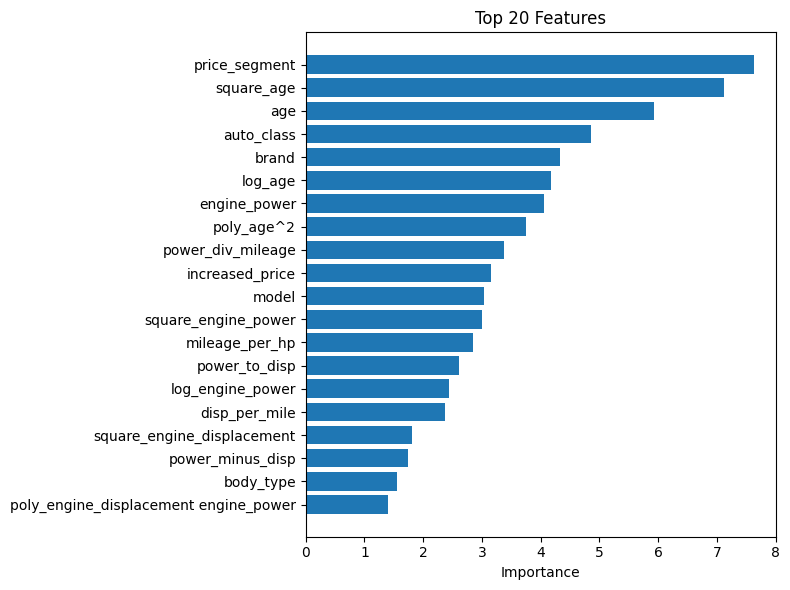

In [ ]:
import matplotlib.pyplot as plt

top = imp_df.head(20)
plt.figure(figsize=(8,6))
plt.barh(top['feature'][::-1], top['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Features')
plt.tight_layout()
plt.show()

### Выводы

$R^2 = 0.9763$

In [ ]:
param = {
    'iterations': 1003, 
    'learning_rate': 0.09702603811009403, 
    'depth': 10, 
    'l2_leaf_reg': 0.11642963038174498, 
    'border_count': 62
}